# PS4-Task1

This is a binary classification task for credit card fraud

## Importing libraries

In [32]:
import numpy as np
import pandas as pd
from datetime import date
from sklearn.preprocessing import LabelEncoder
import pdb
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import xgboost
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import pickle

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Function to preprocess data
# Arguments - Dataset of the read csv file

def preprocessed_dataframe(df):
  # Drop columns that we dont need
  df = df.drop(columns=['ssn', 'cc_num', 'first', 'last', 'street', 'zip', 'city', 'lat', 'long', 'acct_num',
                      'trans_num', 'trans_date', 'unix_time', 'merch_lat', 'merch_long'])

  # Splitting dataframe into numerical and categorical dataframes
  categorical_df = df.copy()
  categorical_df = categorical_df.drop(columns=['dob', 'amt', 'city_pop', 'is_fraud'])
  numerical_df = df.copy()
  numerical_df = numerical_df.drop(columns=['gender', 'state', 'job', 'profile',
                                          'category', 'merchant', 'is_fraud'])
  labels = df['is_fraud'].tolist()  # Saving labels in a list

  # Calculating the age
  def calculateAge(birthDate):
    today = date.today()
    age = today.year - birthDate.year - ((today.month, today.day) < (birthDate.month, birthDate.day))
    return age

  age_arr = []
  for i in numerical_df.index:
    k = numerical_df['dob'][i].split('-')
    j = calculateAge(date(int(k[0]), int(k[1]), int(k[2])))
    age_arr.append(j)

  numerical_df['age'] = age_arr
  numerical_df = numerical_df.drop(columns=['dob'])

  # Filling empty values in numerical_df
  numerical_df = numerical_df.fillna(0)

  # Converting transaction time to categorical, then label encoding
  numerical_df = numerical_df.dropna(axis='rows')
# --------------------------------------------------------------------------------->
  numerical_df['trans_time'].loc[numerical_df['trans_time'][6767]] = '01:00:00'  # This line is specific to training dataset, comment out for testing dataset.
# --------------------------------------------------------------------------------->
  time_arr = []
  for i in numerical_df['trans_time']:
    try:
      if int(str(i).split(':')[0]) < 7:
        time_arr.append('morning')
      elif int(str(i).split(':')[0]) < 13 and int(str(i).split(':')[0]) >= 7:
        time_arr.append('noon')
      elif int(str(i).split(':')[0]) < 19 and int(str(i).split(':')[0]) >= 13:
        time_arr.append('evening')
      elif int(str(i).split(':')[0]) < 25 and int(str(i).split(':')[0]) >= 19:
        time_arr.append('night')
    except ValueError:
      pdb.set_trace()
  numerical_df['trans_time'] = time_arr

  le = LabelEncoder()
  le.fit(np.unique(numerical_df['trans_time'].astype(str)))
  numerical_df['trans_time'] = le.transform(numerical_df['trans_time'])

  # Filling empty values in Categorical_df
  categorical_df = categorical_df.fillna('entertainment', axis='rows')

  # Label encoding categorical df
  categorical_df = categorical_df.drop(columns=['trans_time'])
  le1 = LabelEncoder()
  for i in categorical_df:
    try:
      le1.fit(np.unique(categorical_df[i].astype(str)))
      categorical_df[i] = le1.transform(categorical_df[i])
    except ValueError:
      pdb.set_trace()

  df_merged = pd.concat([numerical_df, categorical_df], axis=1)
  df_merged['is_fraud'] = labels

  return df_merged


In [3]:
data = pd.read_csv('train_data_path')

new_data = preprocessed_dataframe(data)
new_data

,city_pop,trans_time,amt,age,gender,state,job,profile,category,merchant,is_fraud
0,7153,0,10.92,90,0,16,244,5,13,432,0
1,3323,0,221.66,41,0,41,184,1,5,14,0
2,1737737,1,173.74,34,0,9,19,1,4,570,0
3,49523,2,113.66,59,1,26,147,7,7,257,0
4,55878,3,115.46,31,0,41,11,1,10,382,0
...,...,...,...,...,...,...,...,...,...,...,...
700802,3378,0,50.18,42,1,2,95,3,0,323,0
700803,973849,0,7.46,39,1,4,250,3,11,487,0
700804,43002,0,3.72,41,1,47,305,3,6,420,0
700805,238602,0,18.04,94,1,26,284,7,5,248,0


In [43]:
labels = new_data.iloc[:,-1]
labels

0         0
1         0
2         0
3         0
4         0
         ..
700802    0
700803    0
700804    0
700805    0
700806    0
Name: is_fraud, Length: 700807, dtype: int64

In [45]:
df = new_data.iloc[:,:-1]
df

,city_pop,trans_time,amt,age,gender,state,job,profile,category,merchant
0,7153,0,10.92,90,0,16,244,5,13,432
1,3323,0,221.66,41,0,41,184,1,5,14
2,1737737,1,173.74,34,0,9,19,1,4,570
3,49523,2,113.66,59,1,26,147,7,7,257
4,55878,3,115.46,31,0,41,11,1,10,382
...,...,...,...,...,...,...,...,...,...,...
700802,3378,0,50.18,42,1,2,95,3,0,323
700803,973849,0,7.46,39,1,4,250,3,11,487
700804,43002,0,3.72,41,1,47,305,3,6,420
700805,238602,0,18.04,94,1,26,284,7,5,248


In [46]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)

## Baseline

In [48]:
# Initialize XGBoost classifier
model = XGBClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [49]:
# Make predictions
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    139432
           1       0.86      0.60      0.71       730

    accuracy                           1.00    140162
   macro avg       0.93      0.80      0.85    140162
weighted avg       1.00      1.00      1.00    140162



Text(0.5, 192.72222222222217, 'Predicted')

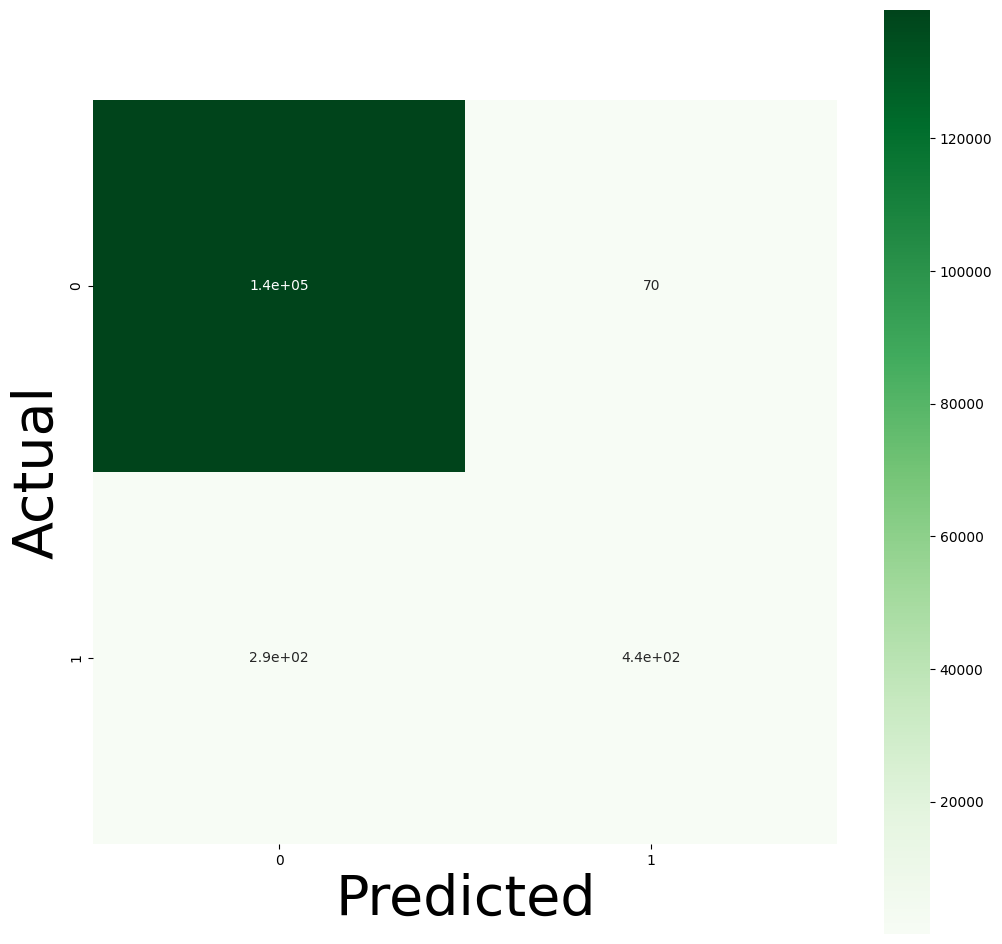

In [50]:
#unique classes in the dataset
classes = ['0','1']
#confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=classes, yticklabels=classes)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
# plt.savefig('cm_cct.png')

## Sampling Strategies

Stratified Sampling

In [12]:
# # target variable (labels)
# y = df.iloc[:, -1]  

# # Splitting the dataset into training and testing sets with stratification strategy
# X_train_ss, X_test_ss, y_train_ss, y_test_ss = train_test_split(df, y, test_size=0.2, stratify=y, random_state=42)

# # Distribution in the training set
# print("Training set distribution:\n", y_train_ss.value_counts(normalize=True))

# # Distribution in the test set
# print("\nTest set distribution:\n", y_test_ss.value_counts(normalize=True))

In [14]:
# model_ss = XGBClassifier(random_state=42)

# model_ss.fit(X_train_ss, y_train_ss)

In [15]:
# y_pred_ss = model_ss.predict(X_test_ss)

# print(classification_report(y_test_ss, y_pred_ss, zero_division=0))

In [16]:
# #confusion_matrix
# cm_ss = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(12, 12))
# ax = sns.heatmap(cm_ss, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=classes, yticklabels=classes)
# ax.set_ylabel('Actual', fontsize=40)
# ax.set_xlabel('Predicted', fontsize=40)
# # plt.savefig('cm_cct.png')

SMOTE Sampling

In [ ]:
# # Splitting the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

# # Applying SMOTE: oversampling technique using synthetic data
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# # Distribution after SMOTE
# print("Distribution after SMOTE:\n", y_train_smote.value_counts())

In [21]:
# model_smote = XGBClassifier(random_state=42)
# model_smote.fit(X_train_smote, y_train_smote)

In [22]:
# y_pred_smote = model_smote.predict(X_test)

# print(classification_report(y_test, y_pred_smote, zero_division=0))

In [23]:
# #confusion_matrix
# cm_smote = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(12, 12))
# ax = sns.heatmap(cm_smote, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=classes, yticklabels=classes)
# ax.set_ylabel('Actual', fontsize=40)
# ax.set_xlabel('Predicted', fontsize=40)
# # plt.savefig('cm_cct.png')

Adjusting class weights

In [28]:
# # Splitting the dataset into training and testing sets
# X_train_cw, X_test_cw, y_train_cw, y_test_cw = train_test_split(df, y, test_size=0.2, random_state=42)

# # Computing class (labels) weights 
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_cw), y=y_train_cw)
# weights = {k: v for k, v in zip(np.unique(y_train_cw), class_weights)}

# # Assigning weights to each instance in the training set
# sample_weights = y_train_cw.map(weights)

In [29]:
# model_cw = XGBClassifier()

# model_cw.fit(X_train_cw, y_train_cw, sample_weight = sample_weights)

In [30]:
# y_pred_cw = model_cw.predict(X_test_cw)

# print(classification_report(y_test_cw, y_pred_cw, zero_division=0))

In [31]:
# #confusion_matrix
# cm_cw = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(12, 12))
# ax = sns.heatmap(cm_cw, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=classes, yticklabels=classes)
# ax.set_ylabel('Actual', fontsize=40)
# ax.set_xlabel('Predicted', fontsize=40)
# # plt.savefig('cm_cct.png')

In [52]:
#saving the model with adjusted class weights
file_path = 'output_file_path'
# Save the model to disk
with open(file_path, 'wb') as file:
    pickle.dump(model, file)

In [53]:
# with open(file_path, 'rb') as file:
#      loaded_model = pickle.load(file)

In [58]:
# y_pred_test = loaded_model.predict(X_test)
# y_pred_test

In [57]:
# print(classification_report(y_test, y_pred_test, zero_division=0))